In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [64]:
def guided_filter(I, p, r, eps):
    """
    Guided filter for edge-preserving smoothing.
    I: guidance image (grayscale float32)
    p: filtering input image (float32)
    r: radius of the guided filter
    eps: regularization parameter
    """
    mean_I = cv2.boxFilter(I, cv2.CV_32F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_32F, (r, r))
    corr_I = cv2.boxFilter(I * I, cv2.CV_32F, (r, r))
    corr_Ip = cv2.boxFilter(I * p, cv2.CV_32F, (r, r))

    var_I = corr_I - mean_I * mean_I
    cov_Ip = corr_Ip - mean_I * mean_p

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_32F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_32F, (r, r))

    q = mean_a * I + mean_b
    return q

In [65]:
def local_tone_mapping(img_bgr, radius=15, eps=1e-3, dodge_burn_strength=1.0):
    """
    Apply local tone mapping with edge-aware smoothing using a guided filter,
    enhancing shadows and toning highlights via dodge & burn on luminance.
    
    Parameters:
    - img_bgr: Input image in BGR uint8 format.
    - radius: Guided filter radius (larger = smoother base layer).
    - eps: Regularization for guided filter to preserve edges.
    - dodge_burn_strength: Controls amount of shadow lifting and highlight taming.
    
    """
    # Convert to LAB color space to work on luminance channel only
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    Lf = L.astype(np.float32) / 255.0  # Normalize luminance to [0,1]

    # Apply guided filter to luminance for base layer extraction
    base = guided_filter(Lf, Lf, radius, eps)

    # Dodge & Burn effect: enhance shadows, tame highlights
    detail = Lf - base
    enhanced_L = Lf + dodge_burn_strength * detail
    enhanced_L = np.clip(enhanced_L, 0, 1)  # Clamp

    # Recombine and convert back to BGR
    enhanced_L_u8 = (enhanced_L * 255).astype(np.uint8)
    enhanced_lab = cv2.merge([enhanced_L_u8, A, B])
    enhanced_bgr = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
    return enhanced_bgr


In [66]:
def display_side_by_side(original_bgr, enhanced_bgr):
    # Convert BGR images to RGB for matplotlib display
    original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)
    enhanced_rgb = cv2.cvtColor(enhanced_bgr, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_rgb)
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(enhanced_rgb)
    axes[1].set_title("Locally Toned Image")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

In [67]:
def save_image(img_bgr, save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    cv2.imwrite(save_path, img_bgr)
    print(f"Saved enhanced image at: {save_path}")

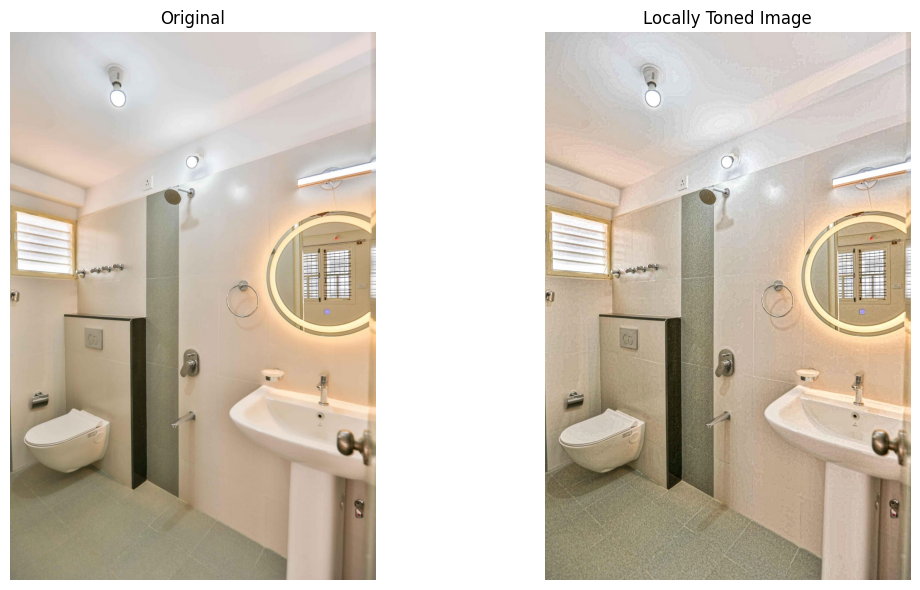

Saved enhanced image at: D:/AutoEnhnace/enhanced_local_tone/local_tonemapped_numbered_56.jpg


In [69]:
if __name__ == "__main__":
    # Update input and output paths as needed
    image_path = r"IMAGE_FOLDER_PATH"
    output_path = r"OUTPUT_FOLDER_PATH_WITH_ENHANCED_IMAGE_LABEL.extension"

    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        exit(1)

    # Run local tone mapping, tweak parameters for best visible effect
    enhanced_img = local_tone_mapping(img, radius=15, eps=1e-3, dodge_burn_strength=2.5)   #1e-3 = 1×(10)^ −3 = 0.001

    display_side_by_side(img, enhanced_img)
    

    save_image(enhanced_img, output_path)